In [157]:

%load_ext autoreload
%autoreload 2

import torch 
import numpy as np 
from dirichlet import * 
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.tri as tri 
import pyro.distributions as dist 
from pyro.contrib.forecast import eval_crps 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [158]:
corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
AREA = 0.5 * 1 * 0.75**0.5
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])

In [159]:
# For each corner of the triangle, the pair of other corners
pairs = [corners[np.roll(range(3), -i)[1:]] for i in range(3)]
# The area of the triangle formed by point xy and another pair or points
tri_area = lambda xy, pair: 0.5 * np.linalg.norm(np.cross(*(pair - xy)))

def xy2bc(xy, tol=1.e-4):
    '''Converts 2D Cartesian coordinates to barycentric.'''
    coords = np.array([tri_area(xy, p) for p in pairs]) / AREA
    return np.clip(coords, tol, 1.0 - tol)

In [162]:
class Dirichlet_exp(object):
    def __init__(self, alpha):
        from math import gamma
        from operator import mul
        self._alpha = np.array(alpha)
        self._coef = gamma(np.sum(self._alpha)) / \
                           np.multiply.reduce([gamma(a) for a in self._alpha])
    def pdf(self, x):
        '''Returns pdf value for `x`.'''
        from operator import mul
        return self._coef * np.multiply.reduce([xx ** (aa - 1)
                                               for (xx, aa)in zip(x, self._alpha)])

def draw_pdf_contours(dist, nlevels=200, subdiv=8, **kwargs):
    import math

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dist.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

    plt.tricontourf(trimesh, pvals, nlevels, cmap='jet', **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')

In [170]:
input = torch.tensor(
    [
        [1.3955, 4.0055, 0.4982],
        [0.9365, 1.7348, 0.6538],
        [0.8418, 1.1311, 0.8694],
        [0.7831, 0.9672, 1.0033],
        [0.7733, 0.9115, 1.0390],
        [0.7841, 0.8904, 1.0234],
        [0.8023, 0.8820, 0.9917]
    ]
)
print(input.shape)

drichilet = dist.Dirichlet(concentration=input)

target = torch.tensor(
    [
        [0.6423, 0.1130, 0.2447],
        [0.6529, 0.1083, 0.2388],
        [0.6555, 0.1102, 0.2343],
        [0.6846, 0.0941, 0.2213],
        [0.9286, 0.0000, 0.0714],
        [0.5860, 0.1297, 0.2843],
        [0.6083, 0.1157, 0.2760]
    ]
)

# value = 1e-08

# target += value
# print(target.shape)

drichilet.log_prob(target)

torch.Size([7, 3])


tensor([-3.6606, -0.3697,  0.3781,  0.4463,     inf,  0.5146,  0.5443])

- Algo requirments: 
    - scan through the 2 dimensional tensor and find places where the number is smaller than 1e-08 or larger than 1-1e-08

In [188]:
## GET LOSS V1 
def get_loss(output:torch.tensor, target:torch.tensor, epsilon:float = 1e-08, threshold: float = 1e-08):

    drichilet = dist.Dirichlet(concentration=output)
    # output 
    # print(f"the batch shape is {output.shape[:-1]}")
    # print(f"the event shape is {output.shape[-1:]}")
    # print(drichilet)

    # target += epsilon
    # print(target.shape) 
    # print(target)
    
    # scan greater values 
    row_indexs = (target >= 1-threshold).nonzero()[:,0]
    col_indexs = (target >= 1-threshold).nonzero()[:,1]

    for i in range(len(row_indexs)): 
        target[row_indexs[i],col_indexs[i]] -= epsilon

        target[row_indexs[i],0:col_indexs[i]] += epsilon/2
        target[row_indexs[i],col_indexs[i]+1:] += epsilon/2
    print(target)
    
    # scan smaller values 
    row_indexs = (target <= threshold).nonzero()[:,0]
    col_indexs = (target <= threshold).nonzero()[:,1]

    for i in range(len(row_indexs)): 
        target[row_indexs[i],col_indexs[i]] += epsilon

        target[row_indexs[i],0:col_indexs[i]] -= epsilon/2
        target[row_indexs[i],col_indexs[i]+1:] -= epsilon/2
    
    print(target)
    print(target.shape)
    print(output.shape)
    # print(target.sum(dim=1))

    loss = drichilet.log_prob(target)
    loss_sum = loss.sum(-1)

    return -loss_sum

In [189]:
input = torch.tensor(
    [
        [1.3955, 4.0055, 0.4982],
        [0.9365, 1.7348, 0.6538],
        [0.8418, 1.1311, 0.8694],
        [0.7831, 0.9672, 1.0033],
        [0.7733, 0.9115, 1.0390],
        [0.7841, 0.8904, 1.0234],
        [0.8023, 0.8820, 0.9917]
    ]
)

target = torch.tensor(
    [
        [0.6423, 0.1130, 0.2447],
        [0.6529, 0.1083, 0.2388],
        [0.6555, 0.1102, 0.2343],
        [0.6846, 0.0941, 0.2213],
        [1, 0, 0],
        [0.5860, 0.1297, 0.2843],
        [0.6083, 0.1157, 0.2760]
    ]
)

In [190]:
get_loss(output=input, target=target, epsilon=1e-07, threshold = 1e-08)

tensor([[6.4230e-01, 1.1300e-01, 2.4470e-01],
        [6.5290e-01, 1.0830e-01, 2.3880e-01],
        [6.5550e-01, 1.1020e-01, 2.3430e-01],
        [6.8460e-01, 9.4100e-02, 2.2130e-01],
        [1.0000e+00, 5.0000e-08, 5.0000e-08],
        [5.8600e-01, 1.2970e-01, 2.8430e-01],
        [6.0830e-01, 1.1570e-01, 2.7600e-01]])
tensor([[6.4230e-01, 1.1300e-01, 2.4470e-01],
        [6.5290e-01, 1.0830e-01, 2.3880e-01],
        [6.5550e-01, 1.1020e-01, 2.3430e-01],
        [6.8460e-01, 9.4100e-02, 2.2130e-01],
        [1.0000e+00, 5.0000e-08, 5.0000e-08],
        [5.8600e-01, 1.2970e-01, 2.8430e-01],
        [6.0830e-01, 1.1570e-01, 2.7600e-01]])
torch.Size([7, 3])
torch.Size([7, 3])


tensor(1.0761)

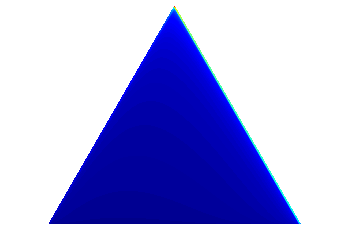

In [163]:
draw_pdf_contours(Dirichlet_exp(alpha = input[4]))

In [5]:
## by Pyro
input = torch.tensor(
    [[2.5335, 1.0041, 0.7144],
    [1.6092, 0.8942, 0.5548],
    [1.2650, 0.8000, 0.5933],
    [1.0805, 0.7738, 0.6637],
    [0.9782, 0.7739, 0.7240],
    [0.9198, 0.7838, 0.7656],
    [0.8854, 0.7958, 0.7913]]
)
print(input.shape)

drichilet = dist.Dirichlet(concentration=input)

target = torch.tensor(
    [[0.6655, 0.1367, 0.1978],
    [0.7197, 0.0738, 0.2065],
    [0.7093, 0.0834, 0.2073],
    [0.7244, 0.0801, 0.1955],
    [0.7356, 0.0760, 0.1884],
    [0.7345, 0.0790, 0.1865],
    [0.7429, 0.0701, 0.1870]]
)

value = 1e-08

target += value
print(target.shape)

drichilet.log_prob(target)

torch.Size([7, 3])
torch.Size([7, 3])


tensor([1.3975, 1.0940, 0.9886, 0.9475, 0.8947, 0.8240, 0.7980])

In [6]:
loss = -40 
log_likelihood = 40 
pdf = np.exp(log_likelihood)
print(pdf)

2.3538526683702e+17


In [7]:
## by Pyro
input = torch.tensor(
    [[2.5335, 1.0041, 0.7144],
    [1.6092, 0.8942, 0.5548],
    [1.2650, 0.8000, 0.5933],
    [1.0805, 0.7738, 0.6637],
    [0.9782, 0.7739, 0.7240],
    [0.9198, 0.7838, 0.7656],
    [0.8854, 0.7958, 0.7913]]
)


target = torch.tensor(
    [[0.6655, 0.1367, 0.1978],
    [0.7197, 0.0738, 0.2065],
    [0.7093, 0.0834, 0.2073],
    [0.7244, 0.0801, 0.1955],
    [0.7356, 0.0760, 0.1884],
    [0.7345, 0.0790, 0.1865],
    [0.7429, 0.0701, 0.1870]]
)



drichilet = dist.Dirichlet(concentration=target)


value = 1e-08

target += value
print(target.shape)

drichilet.log_prob(target)

torch.Size([7, 3])


tensor([-0.6118, -0.5378, -0.5531, -0.5392, -0.5271, -0.5302, -0.5164])

In [ ]:
Dirichlet

In [99]:
## by Pyro
input = torch.tensor(
    [
        [2.5335, 1.0041, 0.7144],
        [200, 100, 10,],
        [200, 100, 100,],
    ]
)

drichilet = dist.Dirichlet(concentration=input)

target = torch.tensor(
    [[0.5,0.2, 0.3],
    [1.0, 0., 0.],
    [1.0, 0., 0.],
    ]
)

print(target)

epsilon = 1e-08

print(-drichilet.log_prob(target)) 

indexs = (target >= 0.99).nonzero()
row_indexs = (target >= 0.99).nonzero()[:,0]
print (f"row indexes: {row_indexs}")
col_indexs = (target >= 0.99).nonzero()[:,1]
print (f"col indexes: {col_indexs}")

epsilon = 1e-05
for i in range(len(row_indexs)): 
    target[row_indexs[i],col_indexs[i]] -= epsilon

    target[row_indexs[i],0:col_indexs[i]] += epsilon/2
    target[row_indexs[i],col_indexs[i]+1:] += epsilon/2

print(target)
print(target.sum(dim=1))

print(-drichilet.log_prob(target))

tensor([[0.5000, 0.2000, 0.3000],
        [1.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000]])
tensor([-0.8417,     inf,     inf])
row indexes: tensor([1, 2])
col indexes: tensor([0, 0])
tensor([[5.0000e-01, 2.0000e-01, 3.0000e-01],
        [9.9999e-01, 5.0000e-06, 5.0000e-06],
        [9.9999e-01, 5.0000e-06, 5.0000e-06]])
tensor([1., 1., 1.])
tensor([-8.4167e-01,  1.0817e+03,  1.9985e+03])


In [93]:
print(target[0,0:1])
print(target[0,1+1:])

tensor([0.5000])
tensor([0.3000])


In [54]:
target

tensor([[5.0000e-01, 2.0000e-01, 3.0000e-01],
        [9.9990e-01, 5.0010e-05, 5.0010e-05],
        [9.9999e-01, 5.0100e-06, 5.0100e-06]])

In [55]:
target

tensor([[5.0000e-01, 2.0000e-01, 3.0000e-01],
        [9.9990e-01, 5.0010e-05, 5.0010e-05],
        [9.9999e-01, 5.0100e-06, 5.0100e-06]])

In [56]:
target.nonzero()

tensor([[0, 0],
        [0, 1],
        [0, 2],
        [1, 0],
        [1, 1],
        [1, 2],
        [2, 0],
        [2, 1],
        [2, 2]])

In [68]:
indexs = (target >= 0.99).nonzero()
row_indexs = (target >= 0.99).nonzero()[:,0]
print (f"row indexes: {row_indexs}")
col_indexs = (target >= 0.99).nonzero()[:,1]
print (f"col indexes: {col_indexs}")

row indexes: tensor([1, 2])
col indexes: tensor([0, 0])


In [78]:
epsilon = 1e-05
target[row_indexs,col_indexs] -= epsilon 
target[row_indexs,~col_indexs] += epsilon/2

In [76]:
target

tensor([[5.0000e-01, 2.0000e-01, 3.0000e-01],
        [9.9880e-01, 5.0010e-05, 6.0001e-04],
        [9.9889e-01, 5.0100e-06, 5.5501e-04]])

In [77]:
print(-drichilet.log_prob(target))

ValueError: Expected value argument (Tensor of shape (3, 3)) to be within the support (Simplex()) of the distribution Dirichlet(concentration: torch.Size([3, 3])), but found invalid values:
tensor([[5.0000e-01, 2.0000e-01, 3.0000e-01],
        [9.9880e-01, 5.0010e-05, 6.0001e-04],
        [9.9889e-01, 5.0100e-06, 5.5501e-04]])

In [64]:
target[row_indexs[0],~col_indexs[0]]

tensor(5.0010e-05)

In [51]:
row_indexs = (target >= 0.99).nonzero()[:,0]
col_indexs = (target >= 0.99).nonzero()[:,1]

(target >= 0.99)

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])

In [25]:
(target >= 0.99).nonzero(as_tuple=True)

(tensor([1]), tensor([0]))

In [11]:
drichilet_2 = Dirichlet(concentration=input)
target = torch.tensor(
    [[0.5,0.2, 0.3],[1.0, 0., 0.]]
)

drichilet_2.log_prob(target, value)

tensor([ 0.8417, 10.4662])

In [12]:
input = torch.tensor(
    [0.5,0.2, 0.3]
)
inference_drichilet = dist.Dirichlet(concentration=input)
val_target_tensor = torch.tensor(
    [0.5,0.2, 0.3]
)
print(type(inference_drichilet))

<class 'pyro.distributions.torch.Dirichlet'>


In [ ]:
#eval_crps -

## step 1: geenrate n_samples of the target from the empirical distrbution, (parameterised by the output)
## step 2: compute the divergence between two distributions (1 == empircal ; 2 = observed values (cdf = step fucniton))

tensor([[0.3048, 0.0988, 0.5964]])
tensor([[9.9744e-01, 2.0433e-06, 2.5622e-03],
        [3.2615e-01, 1.5250e-04, 6.7370e-01]])
tensor([[5.6272e-02, 3.1512e-03, 9.4058e-01],
        [9.8995e-02, 8.9661e-01, 4.3930e-03],
        [5.8721e-01, 8.4368e-04, 4.1194e-01]])
tensor([[8.4622e-01, 7.5165e-04, 1.5302e-01],
        [3.7867e-02, 9.6204e-01, 9.0585e-05],
        [8.7209e-01, 5.3176e-02, 7.4736e-02],
        [9.4192e-01, 3.5216e-04, 5.7724e-02]])
tensor([[7.2751e-02, 4.3818e-08, 9.2725e-01],
        [6.5589e-01, 4.7581e-03, 3.3936e-01],
        [2.0826e-01, 1.7162e-01, 6.2013e-01],
        [6.0727e-01, 3.0887e-02, 3.6184e-01],
        [4.0797e-01, 9.0194e-04, 5.9113e-01]])
tensor([[1.0108e-01, 8.9817e-01, 7.4728e-04],
        [2.8150e-01, 6.7580e-01, 4.2702e-02],
        [3.6022e-02, 9.4304e-01, 2.0939e-02],
        [8.6489e-01, 9.4690e-02, 4.0421e-02],
        [6.3037e-01, 1.6339e-01, 2.0625e-01],
        [9.9345e-01, 2.7590e-06, 6.5430e-03]])
tensor([[5.4395e-01, 4.7618e-02, 4.0843e

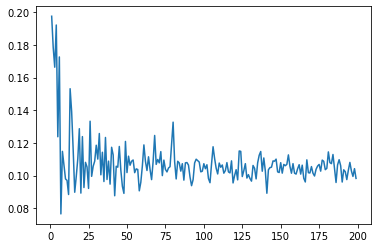

In [191]:
crps = []
n_samples = 200
for i in range(1,n_samples):
    samples = inference_drichilet.sample([i])
    print(samples)
    crps.append(eval_crps(samples, val_target_tensor))
    
plt.figure()
plt.plot(
    list(range(1,n_samples)),
    crps
)
plt.show()

#samples

In [110]:
%%writefile test_plot.py 
import matplotlib.pyplot as plt
import numpy as np

def main():
    # Some example data to display
    x = np.linspace(0, 2 * np.pi, 400)
    y = np.sin(x ** 2) 

    fig, ax = plt.subplots()
    ax.set_title('A single plot')
    ax.plot(x, y)

    return fig 

Overwriting test_plot.py


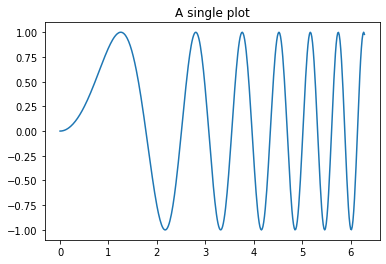

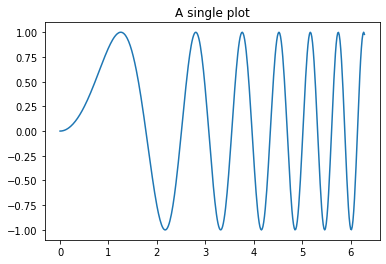

In [111]:
import test_plot 

test_plot.main()

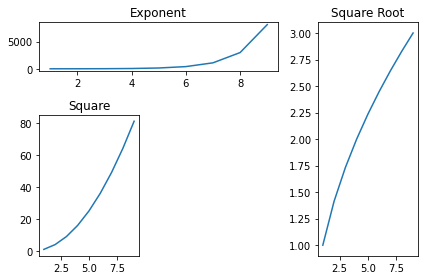

In [114]:
import matplotlib.pyplot as plt
import numpy as np
import math
  
# Placing the plots in the plane
plot1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
plot2 = plt.subplot2grid((3, 3), (0, 2), rowspan=3, colspan=2)
plot3 = plt.subplot2grid((3, 3), (1, 0), rowspan=2)
  
# Using Numpy to create an array x
x = np.arange(1, 10)
  
# Plot for square root
plot2.plot(x, x**0.5)
plot2.set_title('Square Root')
  
# Plot for exponent
plot1.plot(x, np.exp(x))
plot1.set_title('Exponent')
  
# Plot for Square
plot3.plot(x, x*x)
plot3.set_title('Square')
  
# Packing all the plots and displaying them
plt.tight_layout()
plt.show()

<AxesSubplot:>

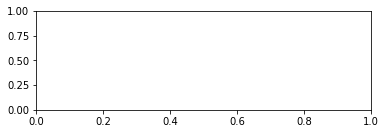

In [125]:
plt.subplot(2,1,1)


In [131]:
torch.sum(samples, dim = -1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 

In [132]:
eval_crps(samples, val_target_tensor)

0.10883140563964844

In [134]:
distributions = Dirichlet(concentration=input)
distributions.concentration

tensor([[1.3955, 4.0055, 0.4982],
        [0.9365, 1.7348, 0.6538],
        [0.8418, 1.1311, 0.8694],
        [0.7831, 0.9672, 1.0033],
        [0.7733, 0.9115, 1.0390],
        [0.7841, 0.8904, 1.0234],
        [0.8023, 0.8820, 0.9917]])

In [135]:
corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
AREA = 0.5 * 1 * 0.75**0.5
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])

In [136]:
# For each corner of the triangle, the pair of other corners
pairs = [corners[np.roll(range(3), -i)[1:]] for i in range(3)]
# The area of the triangle formed by point xy and another pair or points
tri_area = lambda xy, pair: 0.5 * np.linalg.norm(np.cross(*(pair - xy)))

def xy2bc(xy, tol=1.e-4):
    '''Converts 2D Cartesian coordinates to barycentric.'''
    coords = np.array([tri_area(xy, p) for p in pairs]) / AREA
    return np.clip(coords, tol, 1.0 - tol)

In [137]:
class Dirichlet(object):
    def __init__(self, alpha):
        from math import gamma
        from operator import mul
        self._alpha = np.array(alpha)
        self._coef = gamma(np.sum(self._alpha)) / \
                           np.multiply.reduce([gamma(a) for a in self._alpha])
    def pdf(self, x):
        '''Returns pdf value for `x`.'''
        from operator import mul
        return self._coef * np.multiply.reduce([xx ** (aa - 1)
                                               for (xx, aa)in zip(x, self._alpha)])

def draw_pdf_contours(dist, nlevels=200, subdiv=8, **kwargs):
    import math

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dist.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

    plt.tricontourf(trimesh, pvals, nlevels, cmap='jet', **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')

In [138]:
a = torch.tensor([0.9036, 0.9208, 0.9173])
b = torch.tensor([0.7231, 0.1062, 0.1707]) 

diff = a-b 

print(diff)

print(torch.norm(a-b,))
print(torch.norm(diff,))

tensor([0.1805, 0.8146, 0.7466])
tensor(1.1196)
tensor(1.1196)


In [139]:
np.sqrt(0.1805**2 + 0.8146**2 + 0.7466**2)

1.119627156691012

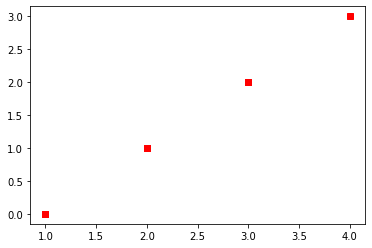

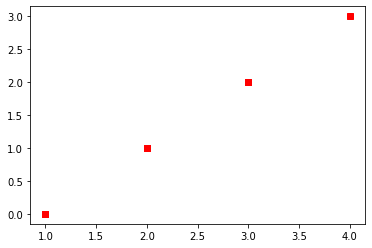

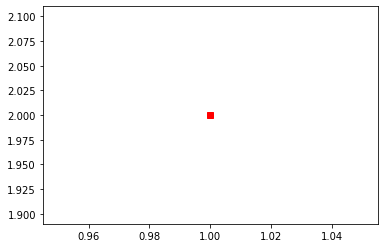

In [140]:
import matplotlib.pyplot as plt 
plt.figure() 
plt.plot([1,2,3], [0,1,2], 'rs', )
plt.plot([1,2,3,4], [0,1,2,3], 'rs', )

plt.figure() 
plt.plot([1,2,3], [0,1,2], 'rs', )
plt.plot([1,2,3,4], [0,1,2,3], 'rs', )



plt.figure() 
plt.plot(1, 2,'rs')

In [141]:
list(range(0+1))

[0]

In [142]:
output = [0.8077, 0.7874, 0.7990]
target = torch.tensor(
    [0.7231, 0.1062, 0.1707]
)

In [143]:
output =  torch.tensor(
    
)
print(output)

TypeError: tensor() missing 1 required positional arguments: "data"

In [144]:
distribution = Dirichlet(output)
distribution.rsample()

AttributeError: 'Dirichlet' object has no attribute 'rsample'

In [145]:
distribution.log_prob(target)

AttributeError: 'Dirichlet' object has no attribute 'log_prob'

In [146]:
distribution.sample_n(4)

AttributeError: 'Dirichlet' object has no attribute 'sample_n'

In [147]:
import math

def lbeta(alpha):
    return sum(math.lgamma(a) for a in alpha) - math.lgamma(sum(alpha))

def ldirichlet_pdf(alpha, theta):
    kernel = sum((a - 1) * math.log(t) for a, t in zip(alpha, theta))
    return kernel - lbeta(alpha)


In [148]:
ldirichlet_pdf(output, target)

0.6453139766208054

In [149]:
m = torch.nn.Softmax(dim=1)  
input = torch.randn(2, 3) 
print(input)
print()
output = m(input) 
print(output)
print()
output_exp = torch.exp(output)
print(output_exp)

tensor([[ 1.1272, -0.8463,  0.9369],
        [-1.6684,  0.0504,  0.9693]])

tensor([[0.5087, 0.0707, 0.4206],
        [0.0486, 0.2713, 0.6800]])

tensor([[1.6632, 1.0733, 1.5228],
        [1.0498, 1.3117, 1.9740]])


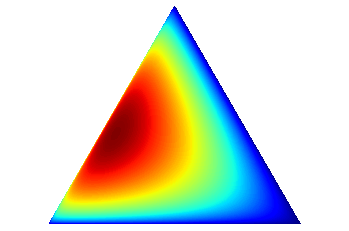

In [150]:
draw_pdf_contours(Dirichlet(output_exp[0]))

In [151]:
torch.clip(torch.tensor([100,200,1]), min = None, max = 100)

tensor([100, 100,   1])

In [152]:
1879%4

3

In [ ]:
1879//4

In [ ]:
469 * 4 

In [ ]:
468*4 

In [ ]:
469*4